In [1]:
#first import dependencies, mainly numpyro
import argparse
import os
import time
from jax.config import config
config.update("jax_enable_x64", True)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

#matplotlib.use("Agg")  # noqa: E402

In [133]:
# create artificial regression dataset
def get_data():
    #idx=np.random.randint(1,6)
    #loc_idx=np.random.randint(48)
    
    #foreground
    sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy').astype(jnp.float64)[:,0:64,192:256].transpose(2,1,0)
    
    #HI signal
    cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:64,192:256].transpose(2,1,0)
    
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((64*64,150))/10000
    cosmos=cosmos.reshape((64*64,150))/10000
    np.random.seed(0)
    X = jnp.linspace(0., 1., sky.shape[1],dtype = jnp.float64)
    #Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    #Y += sigma_obs * np.random.randn(N)
    #Y -= jnp.mean(Y)
    #Y /= jnp.std(Y)

    #assert X.shape == (N,)
    #assert Y.shape == (N,)

    X_test = jnp.linspace(0., 1.,sky.shape[1],dtype = jnp.float64)

    return X, sky+cosmos, X_test

In [151]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-14,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = 100*var * jnp.exp(-0.5 * deltaXsq)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
    return k

# squared exponential kernel with diagonal noise term and fixed variance term
def kernel1(X, Z,var, length, noise, jitter=1.0e-14,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = 100 * jnp.exp(-0.5 * deltaXsq)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.HalfNormal(1))
    #var = 100
    noise = numpyro.sample("kernel_noise", dist.HalfNormal(1))
    length = numpyro.sample("kernel_length", dist.HalfNormal(0.2))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model,init_strategy, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=100,
        num_samples=100,
        num_chains=1,
        thinning=2,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise,is_noise=False)
    k_pX = kernel(X_test, X, var, length, noise,is_noise=False)
    k_XX = kernel(X, X, var, length, noise,is_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y.T)).T
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise




def main():
    X, Y, X_test = get_data()

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    samples = run_inference(model, "median", rng_key, X, Y)

    # do prediction
    vmap_args = (
        random.split(rng_key_predict, samples["kernel_var"].shape[0]),
        samples["kernel_var"],
        samples["kernel_length"],
        samples["kernel_noise"],
    )
    means, predictions = vmap(
        lambda rng_key, var, length, noise: predict(
            rng_key, X, Y, X_test, var, length, noise
        )
    )(*vmap_args)

    mean_prediction = np.mean(means, axis=0)
    percentiles = np.percentile(means, [5.0, 95.0], axis=0)
    
    return X,Y,X_test,mean_prediction,percentiles,samples

    # make plots
    # fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

    # plot training data
    # ax.plot(X, Y, "kx")
    # plot 90% confidence level of predictions
    # ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
    # plot mean prediction
    # ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
    # ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

    # plt.savefig("gp_plot.pdf")

In [152]:
numpyro.set_platform('gpu')
numpyro.set_host_device_count(1)
X,Y,X_test,mean_prediction,percentiles,samples = main()

sample: 100%|█| 200/200 [03:56<00:00,  1.18s/it, 1023 steps of size 6.34e-10. ac



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.43      0.00      0.43      0.43      0.43      4.39      1.14
   kernel_noise      1.80      0.00      1.80      1.80      1.80      4.35      1.61
     kernel_var      0.39      0.00      0.39      0.39      0.39      2.44      2.84

Number of divergences: 0

MCMC elapsed time: 236.2908124923706


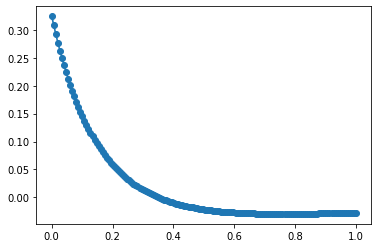

In [153]:
plt.fill_between(X_test, percentiles[0, 0,:], percentiles[1, 0,:], color="lightblue")
plt.scatter(X,Y[0])
plt.plot(X_test,mean_prediction[0])


In [43]:
sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy')

In [138]:
cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:64,192:256].transpose(2,1,0)
    
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(64*64,150)

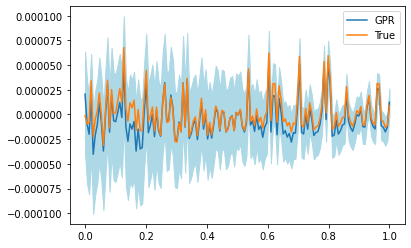

In [157]:
i=1200
plt.plot(X,Y[i]-mean_prediction[i])

plt.plot(X,cosmos[i]/10000)
plt.fill_between(X_test,Y[i]-percentiles[0, i,:], Y[i]-percentiles[1, i,:], color="lightblue")
plt.legend(['GPR','True'])

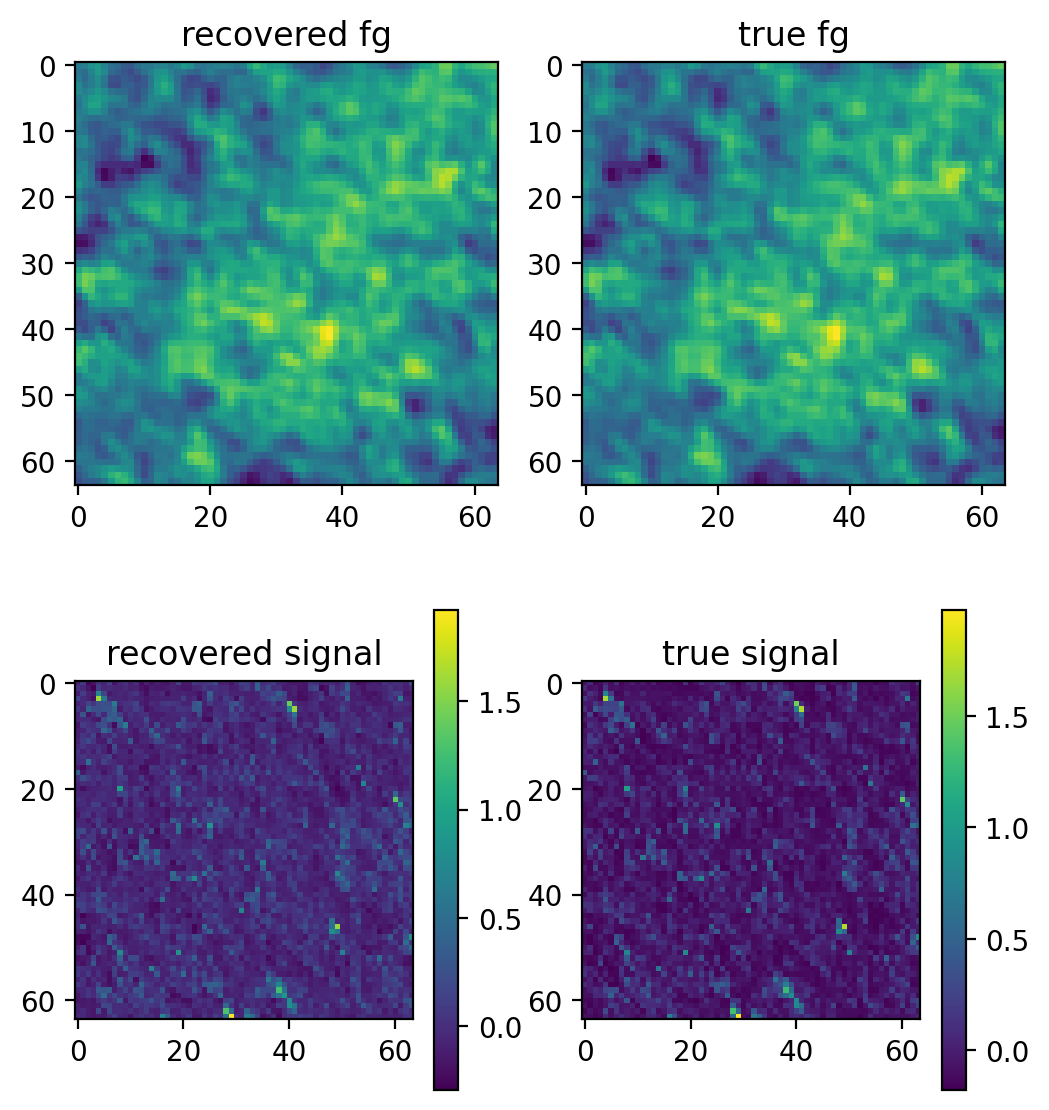

In [156]:
i=100
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(64,64))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y[:,i].reshape(64,64))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y[:,i]-mean_prediction[:,i]).reshape(64,64)*10000)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(64,64))
plt.title('true signal')
plt.colorbar()

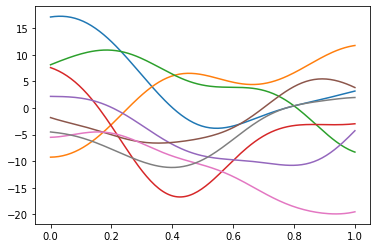

In [116]:
k = kernel(X, X,  0.52016747, 0.23297304, 1.81647456)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        #obs=Y,
        rng_key= rng_key,sample_shape=(8,)
    )
for i in range(8):
    plt.plot(X,samp[i])

In [147]:
numpyro.sample("kernel_var", dist.InverseGamma(10,2),rng_key= rng_key,sample_shape=(16,))

DeviceArray([0.16593575, 0.35661613, 0.44178466, 0.23166905, 0.19851243,
             0.26369422, 0.13496179, 0.21433583, 0.18115296, 0.14783476,
             0.28515543, 0.13975012, 0.13496239, 0.17410843, 0.21726044,
             0.12075873], dtype=float64)

In [30]:
percentiles.shape

(2, 10, 150)

In [125]:
Y.shape

(4096, 150)

In [110]:
k = kernel(X, X, 0.52016747, 0.23297304, 1.81647456)
jnp.mean(dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k).log_prob(Y))

DeviceArray(1264.82178955, dtype=float64)

In [98]:
samples

{'kernel_length': DeviceArray([0.23297319, 0.23297276, 0.23297308, 0.23297283, 0.23297321,
              0.23297304, 0.23297221, 0.23297203, 0.23297202, 0.23297169,
              0.23297242, 0.23297218, 0.23297299, 0.23297327, 0.2329731 ,
              0.23297297, 0.23297345, 0.23297331, 0.23297338, 0.23297334,
              0.2329731 , 0.23297272, 0.23297285, 0.23297291, 0.23297312,
              0.23297357, 0.23297369, 0.23297338, 0.2329736 , 0.23297404,
              0.23297339, 0.23297326, 0.23297369, 0.23297323, 0.23297308,
              0.23297303, 0.23297288, 0.2329725 , 0.23297226, 0.23297212,
              0.23297182, 0.23297094, 0.2329702 , 0.2329704 , 0.23297065,
              0.23297099, 0.23297054, 0.23297048, 0.23297068, 0.23297065],            dtype=float64),
 'kernel_noise': DeviceArray([1.81649506, 1.81649424, 1.81648662, 1.81648157, 1.81647812,
              1.81647456, 1.81647362, 1.81647622, 1.81647347, 1.81647089,
              1.81646899, 1.8164692 , 1.81647185, 1

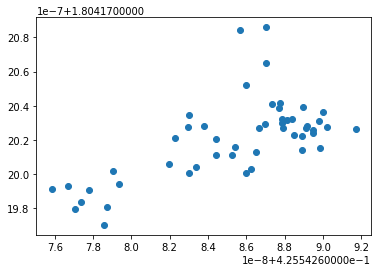

In [141]:
plt.scatter(samples['kernel_length'],samples['kernel_noise'])